In [1]:
!touch pytorch/train.py
!touch pytorch/model.py
!touch pytorch/predict.py
!touch pytorch/requirements.txt
!pip install ipympl

    100% |████████████████████████████████| 942kB 11.8MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 23.1MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 13.2MB/s ta 0:00:01
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
  Found existing installation: widgetsnbextension 3.4.2
    Uninstalling widgetsnbextension-3.4.2:
      Successfully uninstalled widgetsnbextension-3.4.2
  Found existing installation: ipywidgets 7.4.0
    Uninstalling ipywidgets-7.4.0:
      Successfully uninstalled ipywidgets-7.4.0
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [26]:
import pandas as pd

# with cat column
all_test_df = pd.read_csv('./data/s3/AAP/all-test.csv', header=None)
print(all_test_df.shape)
print(all_test_df.columns)
# drop cat and label columns
print(all_test_df.drop(columns=[0, all_test_df.shape[1]-1]).head())
print(all_test_df[0].head())
print(pd.read_csv('./data/s3/AAP/all-train.csv', header=None).shape)
# without cat column
print(pd.read_csv('./data/s3/AAP/train/cluster-0/train.csv', header=None).shape)


(820, 28)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
           dtype='int64')
         1         2         3         4         5         6         7   \
0  0.474236  0.481154  0.481109  0.476836  0.481103  0.044050  0.593691   
1  0.210703  0.211034  0.209755  0.206981  0.207008  0.048963  0.572765   
2  0.158306  0.162271  0.159464  0.160090  0.158871  0.047454  0.585094   
3  0.853103  0.864722  0.859995  0.867820  0.874367  0.037989  0.586299   
4  0.191046  0.188581  0.181766  0.178821  0.178804  0.120609  0.547929   

         8         9         10  ...        17        18        19        20  \
0  0.603550  0.484474  0.496668  ...  0.584272  0.514612  0.194962  0.213138   
1  0.628862  0.632891  0.616624  ...  0.183928  0.190583  0.552224  0.496165   
2  0.602133  0.588146  0.593194  ...  0.164053  0.151994  0.550867  0.555154   
3  0.633949  0.481713  0.796572  ...  0.816113  0.807621

In [27]:
# Build model using PyTorch
import sagemaker
from sagemaker.pytorch import PyTorch
from glob import glob

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
local_data_folder = './data/'
tickers = list(map(lambda x: x.replace(local_data_folder, '').replace('.csv', ''), glob(local_data_folder + "*.csv")))
prefix = "udacity-capstone-project"

def generate_predictor(ticker, cluster):
    s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/data/{}/train/{}/train.csv'\
                                        .format(bucket, prefix, ticker, cluster), content_type='text/csv')
    s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/data/{}/train/{}/validation.csv'\
                                             .format(bucket, prefix, ticker, cluster), content_type='text/csv')

    estimator = PyTorch(entry_point='train.py',
                        source_dir='pytorch', # this should be just "source" for your code
                        role=role,
                        framework_version='1.0',
                        train_instance_count=1,
                        train_instance_type='ml.c4.xlarge',
                        sagemaker_session=sagemaker_session,
                        hyperparameters={
                            'input_dim': 26,  # num of features
                            'hidden_dim': 260,
                            'output_dim': 1,
                            'epochs': 200 # could change to higher
                        })

    estimator.fit({ 'train': s3_input_train, 'validation': s3_input_validation })
    predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
    return predictor

for ticker in tickers[:1]:
    print('Processing', ticker)
    
    test_data = pd.read_csv(local_data_folder + 's3/{}/all-test.csv'.format(ticker), header=None)
    labels = test_data[0]
    test_data.drop(columns=[0, test_data.shape[1]-1], inplace=True)
    
    #cluster-0
    cluster0_predictor = generate_predictor(ticker, 'cluster-0')
    
    clustering_result = cluster0_predictor.predict(s3_input_test.astype('float32').values)
    print(clustering_result)
#     clustering_result = list(map(lambda x:x.label["closest_cluster"].float32_tensor.values[0], clustering_result))
    
#     #cluster-1
#     cluster1_estimator = generate_estimator(ticker, 'cluster-1')
#     #cluster-2
#     cluster2_estimator = generate_estimator(ticker, 'cluster-2')
    

Processing OC
2020-02-17 00:17:57 Starting - Starting the training job...
2020-02-17 00:17:59 Starting - Launching requested ML instances......
2020-02-17 00:19:25 Starting - Preparing the instances for training.........
2020-02-17 00:20:45 Downloading - Downloading input data
2020-02-17 00:20:45 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-02-17 00:21:06,085 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-02-17 00:21:06,088 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-02-17 00:21:06,100 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-02-17 00:21:09,124 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-02-17 00:21:09,403 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-0

NameError: name 's3_input_test' is not defined

In [44]:
test = pd.read_csv(local_data_folder + 's3/AAP/all-test.csv', header=None)
test_labels = test[0]
# print(test_labels)
test.drop(columns=[0, test.shape[1]-1], inplace=True)
clustering_result = cluster0_predictor.predict(test.astype('float32').values)
print(clustering_result.reshape(820))

[0.7047068  0.6712422  0.67789185 0.6150382  0.72501767 0.62158227
 0.6808155  0.60137725 0.659058   0.701615   0.66297287 0.6670415
 0.60315794 0.6393841  0.65912545 0.6367039  0.6210619  0.7141184
 0.66635156 0.6517726  0.6803438  0.7003739  0.66838527 0.6335682
 0.6615374  0.6256984  0.6328812  0.67709446 0.6494342  0.6690653
 0.68828726 0.6355458  0.60889626 0.6404819  0.61784446 0.7109759
 0.61888605 0.6748476  0.72895    0.60905993 0.62901163 0.6285862
 0.685875   0.7283896  0.6290894  0.6268886  0.676529   0.68243957
 0.6402904  0.65415066 0.6496807  0.6234916  0.61937106 0.66581
 0.6110379  0.67462856 0.6628354  0.62114656 0.6507038  0.6087111
 0.74870485 0.7029862  0.7005198  0.6606057  0.6302597  0.6429021
 0.66689616 0.6315222  0.693507   0.6749094  0.6635557  0.6241793
 0.6589052  0.6576185  0.69439244 0.62187153 0.65794384 0.6843714
 0.6558877  0.6574519  0.68547803 0.692916   0.71509534 0.6776775
 0.6338451  0.70015323 0.625382   0.6703955  0.6698302  0.6725585
 0.6409275

In [50]:
cluster0_predictor.delete_endpoint(cluster0_predictor.endpoint)

ClientError: An error occurred (ValidationException) when calling the DeleteEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:us-west-2:825285592721:endpoint-config/sagemaker-pytorch-2020-02-17-00-17-57-399".

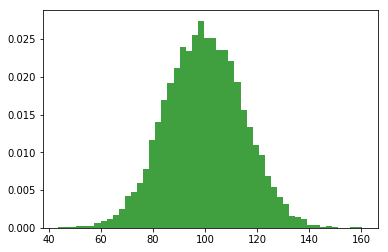

In [5]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Fixing random state for reproducibility
np.random.seed(19680801)

mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)


# plt.xlabel('Smarts')
# plt.ylabel('Probability')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
# plt.grid(True)
plt.show()

In [67]:
import pickle
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sagemaker import KMeans
import os
import numpy as np
from helper.utils import create_dir, clustering, save_data
import matplotlib.pyplot as plt
% matplotlib inline

import sagemaker
from sagemaker.pytorch import PyTorch
from glob import glob

threshold = .4
BUY = 1
SELL = 2
NONE = 3

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
local_data_folder = './data'
prefix = "udacity-capstone-project"
    
# def generate_NN_predictor(ticker):
#     s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/data/{}/train.csv'\
#                                         .format(bucket, prefix, ticker), content_type='text/csv')
#     s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/data/{}/validation.csv'\
#                                              .format(bucket, prefix, ticker), content_type='text/csv')
#     estimator = PyTorch(entry_point='train.py',
#                         source_dir='pytorch', # this should be just "source" for your code
#                         role=role,
#                         framework_version='1.0',
#                         train_instance_count=1,
#                         train_instance_type='ml.c4.xlarge',
#                         sagemaker_session=sagemaker_session,
#                         hyperparameters={
#                             'input_dim': 26,  # num of features
#                             'hidden_dim': 260,
#                             'output_dim': 1,
#                             'epochs': 200 # could change to higher
#                         })
#     estimator.fit({ 'train': s3_input_train, 'validation': s3_input_validation })
#     predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
#     return predictor
    
def generate_accuracy(ticker):
    df = pd.read_pickle('{}/{}.{}'.format(local_data_folder, ticker, 'pkl'))
    df.dropna(inplace=True)
    df.drop(columns=["Date"], inplace=True)
    df.loc[df.Label >= threshold, 'direction'] = BUY
    df.loc[df.Label <= -threshold, 'direction'] = SELL
    df.loc[(df.Label < threshold) & (df.Label > -threshold), 'direction'] = NONE
    print(df.columns)

    # Normalize
    scaler = MinMaxScaler()

    Y_df = pd.DataFrame(df["Label"]).astype('float64')
    X_df = df.drop(columns=["Label"]).astype('float64')

    X = scaler.fit_transform(X_df)
    Y = scaler.fit_transform(Y_df)

    # split data
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.33, random_state=1, shuffle=True)
    
    # clustering
    s3_output_folder = "s3://{}/{}/output".format(bucket, prefix)
    kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type="ml.m4.xlarge",
                output_path=s3_output_folder,
                k=3)

    # Remove direction column
    kmeans.fit(kmeans.record_set(pd.DataFrame(x_train, index=None, columns=None)\
                                 .drop(columns=[len(x_train[0]) - 1])\
                                 .astype('float32').values))

    # deploy
    print("Deploying model", kmeans.model_data)
    kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")


    create_dir('{}/s3/{}'.format(local_data_folder, ticker))

    '''
        Label = Change in price(+ve, -ve, none)
        Direction = BUY, SELL, NONE
        Cluster = cluster_0, cluster_1, cluster_2
    '''
    y_train_df = pd.DataFrame(y_train, columns=["Label"])
    x_train_df = pd.DataFrame(x_train, columns=['col-{}'.format(i) for i in range(x_train.shape[1] - 1)] + ['direction'])
    dataset_with_cluster = pd.concat([y_train_df.astype("float32"), x_train_df.astype("float32"),\
            clustering(x_train_df.drop(columns=["direction"]).astype('float32').values, kmeans_predictor)
        ], axis=1)
    dataset_with_cluster.to_csv('{}/s3/{}/all-train.csv'.format(local_data_folder, ticker), header=True, index=False)

    # delete endpoint
    kmeans_predictor.delete_endpoint(kmeans_predictor.endpoint)

    y_test_df = pd.DataFrame(y_test, columns=["Label"])
    x_test_df = pd.DataFrame(x_test, columns=['col-{}'.format(i) for i in range(x_test.shape[1])] + ['direction'])
    pd.concat([y_test_df.astype("float32"), x_test_df.astype("float32")], axis=1)\
        .to_csv('{}/s3/{}/all-test.csv'.format(local_data_folder, ticker), header=True, index=False)

    print('Completed clustering for', ticker)

#     Analyze cluster_0, cluster_1, cluster_2 and find out which direction do they majorly represent.
#     For example, do we have highest number of BUY in cluster_0? Then cluster_0 is going to represet BUY category




In [68]:
tickers = list(map(lambda x: x.replace(local_data_folder, '').replace('.csv', ''), glob(local_data_folder + "*.csv")))

generate_accuracy('A')

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'N - 1', 'N - 2',
       'N - 3', 'N - 4', 'N - 5', 'N - 6', 'N - 7', 'N - 8', 'N - 9', 'N - 10',
       'Label', 'TRIMA', 'SAR', 'MACD-main', 'MACD-signal', 'MACD-hist', 'RSI',
       'STOCH-k', 'STOCH-d', 'AD', 'ATR', 'direction'],
      dtype='object')
2020-02-17 06:09:58 Starting - Starting the training job...
2020-02-17 06:09:59 Starting - Launching requested ML instances......
2020-02-17 06:11:03 Starting - Preparing the instances for training......
2020-02-17 06:12:26 Downloading - Downloading input data...
2020-02-17 06:12:52 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[02/17/2020 06:13:15 INFO 139868835596096] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info',

ValueError: Shape of passed values is (820, 27), indices imply (820, 28)